In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from assimilation import ExtendedKF, OI, EnKF

In [191]:
def lorenz96_fdm(x0, ts, F=8):
    dt = ts[1] - ts[0]
    x = np.zeros((x0.size, ts.size))
    x[:,0] = x0.ravel()
    
    for idx, time in enumerate(ts[1:]):
        xn = x[:,idx]
        xn_p1 = np.roll(xn, -1)  # x_{n+1}
        xn_m1 = np.roll(xn, 1)  # x_{n-1}
        xn_m2 = np.roll(xn, 2)  # x_{n-2}
        x[:,idx+1] = xn + dt * ((xn_p1-xn_m2) * xn_m1 - xn + F)
        
    return x

def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err

In [193]:
class DAbase:
    def __init__(self, model, dt, store_history=False):
        self._isstore = store_history
        self._params = {'alpha': 0, 'inflat': 1}
        self.model = model
        self.dt = dt
        self.X_ini = None
        
    def set_params(self, param_list, **kwargs):
        for key, value in kwargs.items():
            if key in param_list:
                self._params[key] = kwargs.get(key)
            else:
                raise ValueError(f'Invalid parameter: {key}')
        
    def _check_params(self, param_list):
        missing_params = []
        for var in param_list:
            if self._params.get(var) is None:
                missing_params.append(var)
        return missing_params
    

class OI(DAbase):
    def __init__(self, model, dt, store_history=False):
        super().__init__(model, dt, store_history)
        self._param_list = [
            'X_ini', 
            'obs', 
            'obs_interv', 
            'Pb', 
            'R', 
            'H_func', 
            'H'
        ]
        
    def list_params(self):
        return self._param_list
        
    def set_params(self, **kwargs):
        super().set_params(self._param_list, **kwargs)
        
    def _check_params(self):
        if self._params.get('H_func') is None:
            H_func = lambda arr: arr
            self._params['H_func'] = H_func
        if self._params.get('H') is None:
            H = np.eye(self._params.get('R').shape[0])
            self._params['H'] = H
            
        missing_params = super()._check_params(self._param_list)
        if missing_params:
            raise ValueError(f"Missing parameters: {missing_params}")
            
    def _analysis(self, xb, yo, Pb, R, H_func=None, H=None):
        if H_func is None:
            H_func = lambda arr: arr
            H = np.eye(yo.size)
            
        K = Pb @ H.T @ np.linalg.inv(H @ Pb @ H.T + R)
        xa = xb + K @ (yo - H_func(xb))
        Pa = (np.eye(len(xb)) - K @ H) @ Pb
        return (xa, Pa)
    
    def cycle(self):
        self._check_params()
        
        model = self.model
        dt = self.dt
        cycle_len = self._params['obs_interv']
        cycle_num = self._params['obs'].shape[1]
        
        xb = self._params['X_ini'].copy()
        obs = self._params['obs']
        Pb = self._params['Pb']
        R = self._params['R']
        H_func = self._params['H_func']
        H = self._params['H']
        
        background = np.zeros((xb.size, cycle_len*cycle_num))
        analysis = np.zeros_like(background)
        
        t_start = 0
        ts = np.arange(t_start, cycle_len*dt, dt)
        
        for nc in range(cycle_num):
            # analysis and forecast
            xa, _ = self._analysis(xb, obs[:,[nc]], Pb, R, H_func, H)
            x_forecast = model(xa.ravel(), ts)
            
            # store result of background and analysis field
            idx1 = nc*cycle_len
            idx2 = (nc+1)*cycle_len
            analysis[:,idx1:idx2] = x_forecast
            background[:,[idx1]] = xb
            background[:,(idx1+1):idx2] = x_forecast[:,1:]
            
            # for next cycle
            xb = x_forecast[:,[-1]]
            t_start = int(ts[-1] + dt)
            ts = np.arange(t_start, t_start+cycle_len*dt, dt)
            
        self.background = background
        self.analysis = analysis

### Create nature run

In [194]:
seed = 42
rng = np.random.RandomState(seed)

N = 40  # number of variables
X_ini = rng.randint(0, 10, size=N)
X_ini_perturb = X_ini + rng.randn(N)

# Nature run
F = 8
spin_time = 20
dt = 0.01
ts = np.arange(0, spin_time, dt)
X_nature_spn = lorenz96_fdm(X_ini, ts, F)

time = 16
ts = np.arange(0, time, dt)
X_nature = lorenz96_fdm(X_nature_spn[:,-1], ts, F)
X_nature.shape

# initial condition
F = 8
spin_time = 20
dt = 0.01
ts = np.arange(0, spin_time, dt)
X_spn = lorenz96_fdm(X_ini_perturb, ts, F)
X_ini = X_spn[:,[-1]]   # initial condition for assimilation
X_ini.shape

(40, 1)

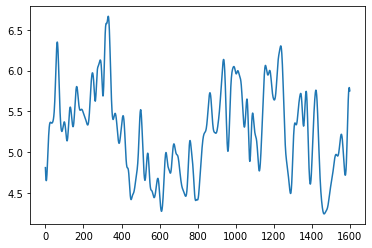

In [195]:
ts = np.arange(0, time, dt)
X_forecast = lorenz96_fdm(X_ini, ts)
rmse = np.sqrt(np.mean((X_forecast-X_nature)**2, axis=0))

plt.plot(rmse);

### OI

In [196]:
obs_var = 1
obs_timeintv = 0.05
obs_intv = int(obs_timeintv / dt)
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((40, size))
for irow in range(40):
    X_obs_err[irow,:] = gen_random_obserr(0, obs_var, size, obs_intv)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]
X_obs.shape

(40, 320)

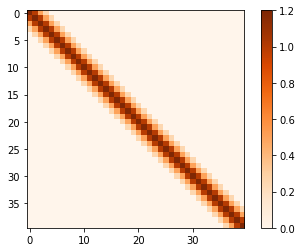

In [197]:
#obs_var = 100
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


Pb = np.eye(40) * obs_var * 1.2
Pb += np.diag(obs_var*np.ones(N-1), k=1) + np.diag(obs_var*np.ones(N-1), k=-1)
Pb += np.diag(0.5*obs_var*np.ones(N-2), k=2) + np.diag(0.5*obs_var*np.ones(N-2), k=-2)
Pb += np.diag(0.25*obs_var*np.ones(N-3), k=3) + np.diag(0.25*obs_var*np.ones(N-3), k=-3)

plt.imshow(Pb, cmap='Oranges', interpolation='nearest')
plt.colorbar();

In [198]:
oi = OI(lorenz96_fdm, dt)
oi.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(40)
}
oi.set_params(**params)
oi.cycle()

In [199]:
oi.analysis.shape

(40, 1600)

background, analysis, obs, nature
-0.96667,  4.01551,  6.47869,  5.89381
 3.87896,  5.46752,  7.40248,  6.17128
 5.15497,  6.13631,  7.37624,  6.55434
 6.27476,  5.87922,  6.33170,  7.13093
 6.26471,  7.15123,  8.38559,  7.97354
 7.77496,  7.89634,  8.85004,  9.02620
 8.65904,  9.12837,  9.91464,  9.98781
 9.76809,  9.01396,  9.77436, 10.34002
 9.07617,  8.27228,  9.52677,  9.62024
 7.47907,  7.37067,  8.54145,  7.68415
 6.12341,  4.89872,  3.90299,  4.76521
 2.68804,  2.39568,  1.36658,  1.35009
 0.07324, -0.05630, -0.37487, -1.93998
-1.64783, -2.53802, -4.84506, -4.37594
-4.06842, -3.79269, -5.71261, -5.32031
-4.52174, -2.47789, -3.81958, -4.63625
-1.88274, -0.55147, -2.77473, -2.85111
 0.23470,  1.36333, -0.89124, -0.79114
 1.92751,  3.24426,  2.57927,  0.95551
 3.47401,  3.25694,  0.85582,  2.19236
 2.98491,  3.28090,  2.78281,  2.91795
 2.74869,  3.84967,  2.64887,  3.12721
 2.60418,  3.27268,  1.15376,  2.74873
 1.75355,  2.16274,  0.85546,  1.72442
 0.47051,  1.26649,  0.15987, 

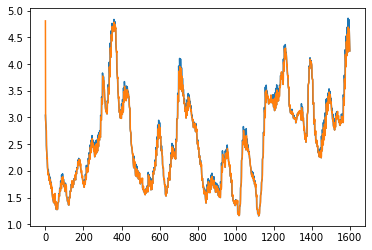

In [200]:
rmse_oi = np.sqrt(np.mean((oi.analysis-X_nature)**2, axis=0))
plt.plot(rmse_oi);

ba_rmse = np.sqrt(np.mean((oi.background-X_nature)**2, axis=0))
plt.plot(ba_rmse);

"""
print('background analysis nature obs')
for i in range(10):
    text = f'{oi.background[0,i]:.6f}, {oi.analysis[0,i]:.6f}, {X_nature[0,i]:.6f}'
    if i % obs_intv == 0:
        text = text + f', {X_obs[0,i//obs_intv]:.6f}'
    print(text)
    
"""    
print('background, analysis, obs, nature')
info = np.vstack([oi.background[0,::obs_intv], oi.analysis[0,::obs_intv], X_obs[0,:], X_nature[0,::obs_intv]]).T
for ii in info:
    text = f'{ii[0]:8.5f}, {ii[1]:8.5f}, {ii[2]:8.5f}, {ii[3]:8.5f}'
    print(text)

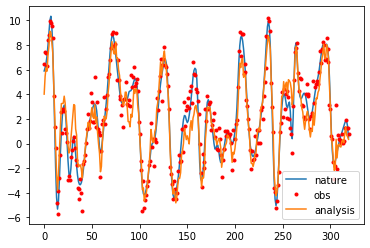

In [201]:
plt.plot(X_nature[0,::obs_intv], label='nature')
plt.plot(X_obs[0,:], 'r.', label='obs')
plt.plot(oi.analysis[0,::obs_intv], label='analysis')
plt.legend()

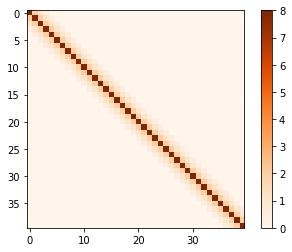

In [141]:
R = np.eye(40) * 2
Pb = R * 4
Pb += np.diag(2*np.ones(N-1), k=1) + np.diag(2*np.ones(N-1), k=-1)
Pb += np.diag(1*np.ones(N-2), k=2) + np.diag(1*np.ones(N-2), k=-2)
Pb += np.diag(0.5*np.ones(N-3), k=3) + np.diag(0.5*np.ones(N-3), k=-3)

min_eig = np.min(np.real(np.linalg.eigvals(Pb)))
if min_eig < 0:
    Pb -= 10*min_eig * np.eye(*Pb.shape)

plt.imshow(Pb, cmap='Oranges', interpolation='nearest')
plt.colorbar();

In [142]:
obs_var = 2
obs_timeintv = 0.08
obs_intv = 8
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((40, size))
for irow in range(40):
    X_obs_err[irow,:] = gen_random_obserr(0, obs_var, size, obs_intv)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]
X_obs.shape

(40, 200)

In [213]:
xb = oi.background[:,::obs_intv][:,[3]]
xa_ = oi.analysis[:,::obs_intv][:,[3]]
yo = X_obs[:,[3]]

print(xb.shape, xa_.shape, yo.shape)
print(Pb.shape, R.shape)

(40, 1) (40, 1) (40, 1)
(40, 40) (40, 40)


In [220]:
H_func = lambda arr: arr
H = np.eye(yo.size)

K = Pb @ H.T @ np.linalg.inv(H @ Pb @ H.T + R)
xa = xb + K @ (yo - H_func(xb))
#Pa = (np.eye(len(xb)) - K @ H) @ Pb
np.hstack([xb, yo, xa-xb, xa])

array([[ 6.2747636 ,  6.3316994 , -0.39554281,  5.8792208 ],
       [ 8.30944607,  6.67628271, -2.09867084,  6.21077524],
       [ 6.03781317,  0.36215443, -2.13082824,  3.90698493],
       [ 1.94443515,  1.63746866, -1.78052907,  0.16390608],
       [ 5.71005814,  4.3397768 , -0.16344455,  5.54661359],
       [ 7.53333905,  9.95092344,  0.17327477,  7.70661382],
       [ 6.95773211,  6.30619767,  0.40912583,  7.36685794],
       [-3.06562517, -4.09636386, -0.04376236, -3.10938753],
       [-0.42882942,  1.65724471,  0.52401498,  0.09518555],
       [ 3.4020268 ,  3.20336756,  0.28700861,  3.6890354 ],
       [ 3.70567988,  4.19272689,  0.24065235,  3.94633222],
       [-0.3144896 , -0.05697159,  0.38454376,  0.07005416],
       [ 0.44164771,  0.60215667,  0.62641974,  1.06806745],
       [ 0.10549657,  2.5424401 ,  1.41157461,  1.51707118],
       [-0.96569012,  0.45493088,  1.03611924,  0.07042912],
       [ 5.65176105,  6.38577452,  0.36146049,  6.01322154],
       [ 1.35117781,  0.

### EnKF

In [143]:
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (40, N_ens)
X_ens_ini += 3 + 2 * np.random.randn(40, 1)
#X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (40, N_ens)

enkf = EnKF(lorenz96_fdm, dt)
enkf.list_params()
params = {
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.5
}
enkf.set_params(**params)
enkf.cycle()

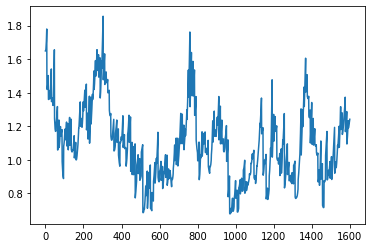

In [144]:
ens_mean = enkf.analysis.mean(axis=0)
rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
plt.plot(rmse_enkf);

In [121]:
inflats = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2]
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for inflat in inflats:
    for alpha in alphas:
        enkf = EnKF(lorenz96_fdm, dt)
        enkf.list_params()
        params = {
            'X_ens_ini': X_ens_ini,
            'obs': X_obs,
            'obs_interv': 8,
            'R': R,
            'H_func': lambda arr: arr,
            'alpha': 0.4,
            'inflat': 1.5
        }
        enkf.set_params(**params)
        enkf.cycle()

        ens_mean = enkf.analysis.mean(axis=0)
        rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
        print(inflat, alpha, rmse_enkf.mean())

1 0 0.9257911632580722
1 0.1 1.031273990041626
1 0.2 0.9664808637349941
1 0.3 1.066779082306364
1 0.4 1.0000994026591947
1 0.5 1.2105093832162026
1 0.6 1.0185737225438138
1 0.7 0.9714133015447436
1 0.8 0.9815591911925577
1.1 0 1.0241183753878007
1.1 0.1 1.3140252431001165
1.1 0.2 0.9829518937708386
1.1 0.3 1.0757430976640752
1.1 0.4 1.1197172867393264
1.1 0.5 1.2465842613652638
1.1 0.6 0.950616545439582
1.1 0.7 1.0581260638395276
1.1 0.8 1.0849187388088408
1.2 0 0.9789816540480595
1.2 0.1 1.023131841466013
1.2 0.2 1.0485804229717217
1.2 0.3 0.9905165487217752
1.2 0.4 1.130779343067622
1.2 0.5 0.942423236743406
1.2 0.6 0.987168334853033
1.2 0.7 1.0895186831265742
1.2 0.8 0.9764137747785342
1.3 0 1.01000618252946
1.3 0.1 1.0505534959414875
1.3 0.2 0.9587683509891537
1.3 0.3 1.1408645411509182
1.3 0.4 1.1336632247601
1.3 0.5 1.1257819540849996
1.3 0.6 0.9789743434786317
1.3 0.7 1.0573159382947122
1.3 0.8 1.0330778624294006
1.4 0 1.0662371732986258
1.4 0.1 1.0858724586804374
1.4 0.2 0.8956